# Advantage Actor-Critic


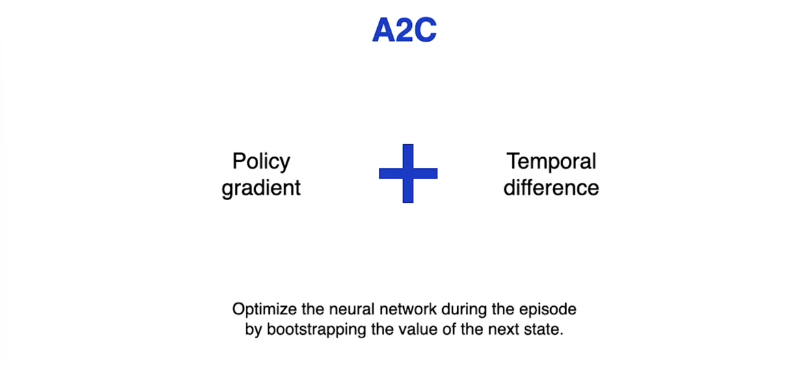

### The Advantage Function

$Adv_𝛑(s,a) = q_𝛑(s,a) - v_𝛑(s)$

- This function measures the excess return that the agent gets when it chooses a particular action in the current state instead of letting the policy choose it.
- the advantage function is the difference between the q-value of an action and the value of a state.
- It tells us the **extra return** that this action gets (__above__ the return of the policy or __below__, if the value is negative).

- `v_𝛑(s)`: is the value based on the policy!
- `q_𝛑(s,a)`: is the value based on taking an action in a given state (not came from the policy).


#### How we can interpret the value of the `Advantage Function`

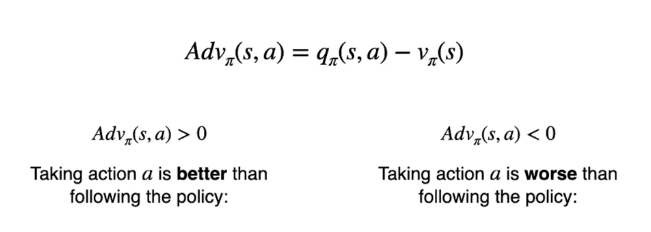

> We want to __reinforce__ the actions that obtain __better__ results and __discourage__ those that obtain __worse__ results.

__We can estimate the advantages of of an action as:__

$Adv_𝛑(s,a) = r(s,a) + γv(s') - γv(s)$

__So let's wrap all together__



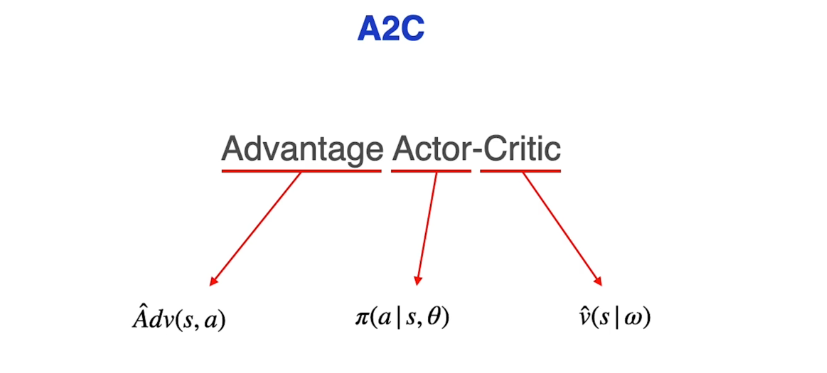

- __Advantage__: because we are going to use the `Advantage Function` to guide the __optimization__ of the policy.
- __Actor__ beacuse it'll use a neural network that will act on the environment (__that is the policy__).
- __Critic__: because we are going to use a neural network that is going to estimate the values of the states and we're going to use it to refine the estimation of the advantage.

__Update rule__
- We have to replace the return by the estimate advantage.
__Where__
- we'll calculate the estimate advantage as the temporal difference error.

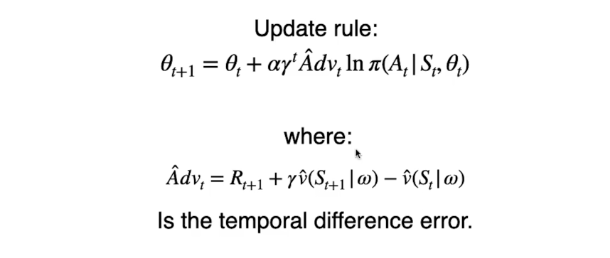

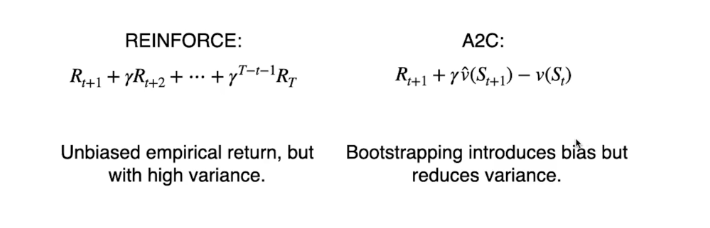

In [ ]:
!apt-get install -y xvfb

!pip install \
  gymnasium==0.26.3 \
  pygame \
  pytorch-lightning==1.6 \
  pyvirtualdisplay

#### Setup virtual display

In [ ]:
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

#### Import the necessary code libraries

In [ ]:
import copy
import torch
import random
import gym
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from torch.distributions import Normal

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, NormalizeObservation


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [ ]:
@torch.no_grad()
def test_env(env_name, policy, obs_rms, **kwargs):
  """
  testing the policy in the environment.

  Parameters
  ----------
  - `env_name`: the name of the environment
  - `policy`: our trained policy (neural network policy - the Actor)
  - `obs_rms`: toom mean square of the observation
     (must be the same in the train and test envs, its a normalize factor.)
  """
  env = gym.make(env_name, **kwargs) # make the environment
  env = RecordVideo(env, 'videos', episode_trigger=lambda e: True) # record video wrraper
  env = NormalizeObservation(env) # normalize observations
  env.obs_rms = obs_rms # set the root mean square of the observations
  policy = policy.to(device) # push the policy to the appropriate devise.
  # > we dont need to normalize the rewards, beacuse its test moode, so we
  #   dont make with them any calculation for improve the policy...

  # loop over the epicodes
  for episode in range(10):
    done = False
    obs = env.reset() # get the initial state
    while not done:
      loc, scale = policy(obs) # send the state to the policy, get back mean/std
      action = torch.normal(loc, scale) # based on that, create normal distribution
      action = action.cpu().numpy() # take the numpy
      obs, _, done, _ = env.step(action) # perform the action
  del env


def display_video(episode=0):
  """
  return a video in HTML format.
  """
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the policy

In [ ]:
class GradientPolicy(nn.Module):
  """
  The policy gradient (Actor).
  ----------------------------

  The Actor going to be the policy.
  this policy predict (in a given state) the mean and std
  of our action distribution, in order to sample the action we want to take.
  """

  def __init__(self, in_features, out_dims, hidden_size=128):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_size) # Input: state
    self.fc2 = nn.Linear(hidden_size, hidden_size) # Hidden layer
    self.fc_mu = nn.Linear(hidden_size, out_dims)  # Output 1: mean
    self.fc_std = nn.Linear(hidden_size, out_dims) # Output 2: std

  def forward(self, x):
    # forward propegate
    x = torch.tensor(x).float().to(device)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    # loc -> mean
    # why *2 ? beacuse the valid range of actions if from -2 to 2.
    # the tanh going to return value in range of [-1,1],
    # so we multiply that by to for reach range of mean of [-2 , 2].
    # this is the requirements of the env.
    loc = self.fc_mu(x)
    loc = torch.tanh(loc) * 2

    # scale -> std
    scale = self.fc_std(x)
    scale = F.softplus(scale) + 0.001

    # return the mean, std.
    return loc, scale

In [ ]:
class ValueNet(nn.Module):
  """
  The Critic
  ----------

  That is a neural network that will evaluate the
  states we visit in order to compute our advantage.
  (estimate the value of a state)
  """
  def __init__(self, in_features, hidden_size=128):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_size) # Input: state
    self.fc2 = nn.Linear(hidden_size, hidden_size) # Hidden lauer
    self.fc3 = nn.Linear(hidden_size, 1) # Output: Value if a state

  def forward(self, x):
    x = torch.tensor(x).float().to(device)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    # return the estimated value. ir can go from [-inf,inf]
    return x

#### Create the environment

In [ ]:
# Create the Pendulum environment.
env = gym.make("Pendulum-v1")

# reset and get the initial state
env.reset()

In [ ]:
# Let's Plot the environment
# all what we need to to is to retate the pendulum for make the point up.
import matplotlib.pyplot as plt
plt.imshow(env.render(mode="rgb_array"))

#### Let's invest the environment

In [ ]:
# Create an environment
env = gym.vector.make("Pendulum-v1", num_envs=2)

In [ ]:
# get the initial state:
env.reset()

# interpretation:
# - we get 2 rows, beacuse we have two copies of the env.
# - each row contain 3 elements: the position and velocity of the pendulum

In [ ]:
print("Observation space")
print(env.observation_space)
print("")
print("Action space:")
print(env.action_space)

# Interpret the observation space:
# - the observation going in range of [-1. -1. -8.] to [1. 1. 8.]

# Interpret the action space:
# - we perform one action. the action have range of: [-2.0, 2.0]

In [ ]:
# let's perform an action from a random policy.
next_obs, rewards, dones, infos = env.step(env.action_space.sample())

In [ ]:
infos

In [ ]:
next_obs

In [ ]:
def create_env(env_name, num_envs):
  """
  Function to create the environment.
  """
  env = gym.vector.make(env_name, num_envs) # create env(s)
  env = RecordEpisodeStatistics(env) # wrap the env in a record epicode
  env = NormalizeObservation(env) # normalize the observations
  return env

#### Create the dataset

In [ ]:
class RLDataset(IterableDataset):
  """
  The an IterableDataset (iterable dataset) of the A2C.

  Parameters
  -----------
  - `env`: the environment
  - `policy`: our policy (a neural network policy - the Actor)
  - `steps_per_epoch`: how many transition create in each epoch
  """
  def __init__(self, env, policy, steps_per_epoch):
    self.env = env
    self.policy = policy
    self.steps_per_epoch = steps_per_epoch
    self.obs = env.reset()

  @torch.no_grad() # -> (don't affect the updates of our neural networks.)
  def __iter__(self):
    """
    Iter method for create dataset of samples of experiences (s,a,r,done,s')
    (to perform a training step)
    """
    # loop `n` step for create transition
    for step in range(self.steps_per_epoch):
      loc, scale = self.policy(self.obs) # get prediced mean & std of the action distribution
      action = torch.normal(loc, scale)  # create Gaussian of action distribution
      action = action.cpu().numpy() # get its numpy (the env work with numpy.)
      next_obs, reward, done, info = self.env.step(action) # perform the action
      yield self.obs, action, reward, done, next_obs # return the experience
      self.obs = next_obs # update the observation

#### Create the A2C algorithm

In [ ]:
class A2C(LightningModule):
  """
  The A2C algorithm implementation using `LightningModule`.

  Parameters:
  ------------
  - `env_name`: the name of the environment
  - `num_envs`: number of the environments
  - `samples_per_epoch`: how mant sample we want per epoch (steps)
  - `batch_size`: how many of those samples will process at once.
  - `hidden_size`: size of hidden layer (both to Actor and Critic)
  - `policy_lr`: learning rate of the Policy
  - `value_lr`: learning rate of the Value
  - `gamma`: discount factor when updating the target (reward)
  - `entropy_coef`: the coefficient of the entropy (how much the entropy effect on the loss)
  - `optim`: optimzer for update the Policy (Actor) and the value (Critic) wigths.
  """

  def __init__(self, env_name, num_envs=64, samples_per_epoch=8,
               batch_size=1, hidden_size=64, policy_lr=1e-4, value_lr=1e-3,
               gamma=0.99, entropy_coef=0.01, optim=AdamW):

    super().__init__()

    # create env
    self.env = create_env(env_name, num_envs=num_envs)

    # Input shape (state dim)
    obs_size = self.env.single_observation_space.shape[0]
    # Output shape (action dim)
    action_dims = self.env.single_action_space.shape[0]

    # Initial Policy (Actor)
    self.policy = GradientPolicy(obs_size, action_dims, hidden_size)
    # Initial Value estimator (Critic)
    self.value_net = ValueNet(obs_size, hidden_size)

    # to stabilize the computations of the value of the state, we atr going
    # to create a copy value_net (Copy of the critic), that will keep
    # a value constant for a few epicodes to stable the target that the compute.
    self.target_value_net = copy.deepcopy(self.value_net)

    # create the dataset
    self.dataset = RLDataset(self.env, self.policy, samples_per_epoch)

    # for convince, save the hyperparemters so we can access them easily.
    self.save_hyperparameters()

  def configure_optimizers(self):
    """
    Configure the optimzers of the
    Policy neural network (Actor) and estimator value neural network (Critic).
    """
    # Optimizer for Value network
    value_opt = self.hparams.optim(self.value_net.parameters(),# parameters (weigths to update)
                                   lr=self.hparams.value_lr)   # learning rate
    # Optimizer for Policy network
    policy_opt = self.hparams.optim(self.policy.parameters(),  # parameters (weigths to update)
                                    lr=self.hparams.policy_lr) # learning rate
    return value_opt, policy_opt

  def train_dataloader(self):
    """
    Use for fatch data from our dataset for a training step.
    """
    return DataLoader(dataset=self.dataset, # our dataset object
                      batch_size=self.hparams.batch_size) # batch size

  def training_step(self, batch, batch_idx, optimizer_idx):
    """
    Execute a training step.
    updates the neural networks (the Policy & Actor).

    implements the Advantage Actor-Critic (AC2) algorithm.
    The Critic (value network) is trained to minimize the difference between
    predicted state values and target values,
    while the actor (policy network) is trained to maximize the
    expected cumulative reward (policy gradient)
    with an additional term encouraging exploration (entropy).

    State Values:
    ------------
    - the state value `v(s)` represent the expected cumelative reward that
      an agent can obtain from a given state (`s`), and folowing after
      a certin policy.

    Target Values:
    -------------
    - the target value is used as a target for training the
      value network (critic). It represents the sum of the
      immediate reward and the discounted expected future rewards.

    Advantage Function:
    -------------------
    - The Advantage Function `A(s,a)` is the different between the
      target value of taking action `a` in state `s` (Q(s,a)) and the
      value of being in state `s` (V(s))
    - A(s,a) = Q(s,a) - V(s)

    Parameters
    -----------
    - `batch`: the batch that contain the samples (s,a,s',r,done).
    - `batch_idx`: the index of the batch
    - `optimizer_idx`: the index of the optimizer
       (there is an optimzer for the Actor and the critic separately.
       so we need to send the optimizer of the specific nn, we have 2 optimizer.)
    """

    # 1. store the number of samples and number of environments.
    #    how many samples and how mant environments we have ?
    samples, envs = batch[0].shape[0:2]
    # 2. reshape the tensor of experience to 1D array, size of samples * envs
    reshape_fn = lambda x: x.view(samples * envs, -1)
    # 3. extract from that batch our tensors,
    #    by applying the reshape function to each of the element in the batch.
    # - now we got 1D array of each component.
    obs_b, action_b, reward_b, done_b, next_obs_b = map(reshape_fn, batch)

    # 4. compute the value of the state using out Value nn (Critic)
    # this is the value of the current observation.
    state_values = self.value_net(obs_b) # v(s)

    #  -------- Critic improvment ------------

    # 5. now, we compute the target value, which'll help us to update
    #    the value network.
    with torch.no_grad():
      # use the Target Value Network for predict the value of the next state
      next_state_values = self.target_value_net(next_obs_b) # v(s')
      # in the rows where the episode is done, set the next state values to zero.
      # why ? beacuse we dont expect to obtain any extra rewards after the
      # task is over.
      next_state_values[done_b] = 0.0
      # compute the target value (the true.)
      # reward + discount * value of next state.
      target = reward_b + self.hparams.gamma * next_state_values

    # 6. check the if the index of the optimizer is 0
    #    (its the optimizer of the Value neural network (Critic))
    # So we compute the loss of the Critic
    # (we must the the Critic will improve its V estimations.).
    if optimizer_idx == 0:
      # take the loss between the state value, and the target value.
      loss = F.smooth_l1_loss(state_values, target) # loss of v(s) & v(s')
      # log it.
      self.log("episode/Value Loss", loss)
      # return the loss.
      return loss

    #  -------- Actor improvment ------------

    # 7. check the if the index of the optimizer is 1
    #    (its the optimizer of the Policy neural network (Actor))
    # Here we update the policy
    elif optimizer_idx == 1:
      # estimated the advantage function:
      # its the different between the target and the state values
      # advantages = Q(s,a) - v(s)
      advantages = (target - state_values).detach()

      # predict the action (mean & std of the action distribution)
      loc, scale = self.policy(obs_b)
      # based on the mean & std, create a normal distribution
      dist = Normal(loc, scale)

      # compute the log probability of the action,
      # given the normal action distribution.
      log_probs = dist.log_prob(action_b).sum(dim=-1, keepdim=True)

      # compute the entropy of the distribution.
      # (its the measure of the randomness of our policy)
      # we sum the entropy values of each action into a single value.
      # in other words, its the total entropy of the distribution.
      entropy = dist.entropy().sum(dim=-1, keepdim=True)

      # compute the loss of the Policy gradient:
      # its the minus log probability * the advantage function.
      # its make sance.
      # the advantage is the different between the target and the state values.
      pg_loss = - log_probs * advantages
      # compute the full loss (take in account the entropy.)
      loss = (pg_loss - self.hparams.entropy_coef * entropy).mean()

      # log the policy loss and the entropy.
      self.log("episode/PG Loss", pg_loss.mean())
      self.log("episode/Entropy", entropy.mean())

      # return the loss.
      return loss

  def training_epoch_end(self, training_step_outputs):
    """
    Callback function where the epoce in the training is iver.
    """
    # each 25 epochs, we log the return of that epicode.
    if self.current_epoch > 0 and self.current_epoch % 25 == 0:
      self.log("episode/Return", self.env.return_queue[-1])

    # each 10 epochs, update the:
    # target value neural network -> with the Value neural network (the main)
    if self.current_epoch > 0 and self.current_epoch % 10 == 0:
      self.target_value_net.load_state_dict(self.value_net.state_dict())

#### Purge logs and run the visualization tool (Tensorboard)

In [ ]:
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

#### Train the policy

In [ ]:
algo = A2C("Pendulum-v1")

trainer = Trainer(
    gpus=num_gpus,
    max_epochs=2000,
    log_every_n_steps=1
)

trainer.fit(algo)

#### Check the resulting policy

In [ ]:
import warnings
warnings.filterwarnings('ignore')

test_env('Pendulum-v1', algo.policy, algo.env.obs_rms)

In [ ]:
display_video(episode=5)